In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import json
from glob import glob
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 1. 处理文件

## 1.1 处理ini文件

In [2]:
# 数据处理函数
def process_screw(num, screw):
    # 定义需要提取的字段
    fields = [
        'FillDataOK', 'FinalTorque', 'FinalAngle', 'jiajinli',
        'MaxAngle', 'MinAngle', 'ScrewNum', 'PostPressForce', 'Result'
    ]
    item = {field: screw.get(field, '') for field in fields}
    
    # 处理Point数据
    point = screw.get('Point', {})
    item['Point_X'] = point.get('X', '')
    item['Point_Y'] = point.get('Y', '')
    
    # 截取前5个数据点
    torque_data = screw.get('TorqueData', {}).get('$values', [])
    # item['TorqueData'] = ', '.join(map(str, torque_data)) if torque_data else ''
    item['TorqueData'] = torque_data
    
    angle_data = screw.get('AngleData', {}).get('$values', [])
    # item['AngleData'] = ', '.join(map(str, angle_data)) if angle_data else ''
    item['AngleData'] = angle_data

    item['ScrewIndex'] = num
    
    return item

def parsefile(file):
    with open(file, 'r', encoding='utf-8') as f:
        content = f.read().strip()

    # 去除可能的非JSON部分（如头部注释）
    cleaned_content = ("{" + content.split("{", 1)[-1].rsplit("}", 1)[0] + "}").strip()
    data = json.loads(cleaned_content)

    screw_index = {0: 4, 1: 2, 2: 1, 3: 41}
    # 提取数据
    rows = []
    for idx, group in enumerate(data['atlasData']['$values'][:4]):
        item = process_screw(screw_index.get(idx), group['$values'][0])
        item['time'] = data['WatchId']
        item['HsgSn'] = data['HsgSn']
        rows.append(item)

    # 创建DataFrame
    df = pd.DataFrame(rows)
    return df

In [3]:
files = glob("../datas/NPI-LG锁螺丝原始数据-20250716-0731/*/*.ini")
dfs = []

for file in files:
    dfs.append(parsefile(file))

df = pd.concat(dfs, ignore_index=True)
df.columns = [x.lower() for x in df.columns]
df['time'] = pd.to_datetime(df['time'].str[:12], format='%Y%m%d%H%M%S')

In [4]:
df['row_index'] = df.groupby(['hsgsn'])['hsgsn'].cumcount()
df = df.sort_values(['time', 'row_index'])[[      # , 'jiajinli' 'point_x', 'point_y'
    'hsgsn', 'time', 'screwindex', 'torquedata', 'angledata', 'result', 'filldataok', 'finaltorque', 
    'finalangle', 'maxangle', 'minangle', 'screwnum',
]]

In [6]:
df.to_csv("../datas/NPI-LG锁螺丝原始数据-20250716-0731/npi_lg_details.csv", index=False)

## 1.2 join tcm datas

In [7]:
tcm_datas = pd.read_csv("../datas/NPI数据收集/LG-1/tcmdata.csv")

In [ ]:
df_use = pd.merge(df, tcm_datas, how="inner", left_on=['hsgsn', 'screwindex'], right_on=['SN', 'screw position'])
df_use.to_csv("../datas/screw_tcm.csv", index=False)

# 2. 分析

In [13]:
df_use['recommended_action'].value_counts()

recommended_action
Continue    7506
Rework        11
FA             3
Name: count, dtype: int64

## 2.1 绘图

In [14]:
print(df_use.columns.tolist())

['hsgsn', 'time', 'screwindex', 'torquedata', 'angledata', 'result', 'filldataok', 'finaltorque', 'finalangle', 'maxangle', 'minangle', 'screwnum', 'DateTime', 'Pass/Fail', 'filename', 'SN', 'screw position', 'screw number', 'failure_clamp', 'failure_slip', 'failure_rehit', 'failure_angle', 'failure_trigger_lost', 'failure_free_spin', 'failure_cross_thread', 'failure_target_torque', 'failure_excess_friction', 'failure_script', 'failure_clamptorque_spec', 'failure_clampangle_spec', 'failure_loaddata', 'target_torque_result', 'clamp_torque_result', 'clamp_angle_max_result', 'clamp_angle_min_result', 'recommended_action', 'angle_start', 'angle_max', 'torque_start', 'torque_max', 'torque_final', 'clamp_torque', 'clamp_angle', 'torque_sit', 'angle_sit', 'max_torque_before_sit', 'angle_at_maxTorque_before_sit', 'angular_work_total', 'angular_work_after_sit', 'angular_work_before_sit', 'clamp_torque_percentage', 'torque_sit_percentage', 'Normalized_integral', 'gradient_mean', 'gradient_stdev'

### 2.1.1 Fail

In [62]:
# ==================== 数据预处理 ====================
def validate_data(row):
    """验证每个样本的angle和torque数据长度是否一致"""
    if len(row['angledata']) != len(row['torquedata']):
        print(f"警告：样本 {row.name} 的angledata和torquedata长度不一致（{len(row['angledata'])} vs {len(row['torquedata'])}），已跳过")
        return False
    return True

def filter_negative_values(angle_list, torque_list, min_value=0):
    """
    同步过滤angle和torque中的负值数据（保留两者均≥min_value的点）
    返回过滤后的(angle_sublist, torque_sublist)
    """
    # 生成索引列表，仅保留两者均≥min_value的位置
    valid_indices = [
        idx for idx, (a, t) in enumerate(zip(angle_list, torque_list)) 
        if a > min_value and t > min_value
    ]
    # 提取过滤后的子列表（若没有有效数据返回空列表）
    angle_sub = [angle_list[idx] for idx in valid_indices] if valid_indices else []
    torque_sub = [torque_list[idx] for idx in valid_indices] if valid_indices else []
    return angle_sub, torque_sub

# ==================== 绘图函数 ====================
def plot_comparison(valid_groups, grouped, screw_order, random_state=2):
    n_groups = len(valid_groups)
    n_rows = (n_groups + 3) // 4  # 每行最多4个，向上取整
    n_cols = min(n_groups, 4)

    # 创建画布（总尺寸根据子图数量调整）
    total_fig_size = (n_cols * 4, n_rows * 3)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=total_fig_size, constrained_layout=True)
    axes = axes.ravel()  # 展平为一维数组方便循环
    
    screw_colors = plt.cm.get_cmap('tab10', 4)  # 使用tab10色卡（支持10种索引）
    screw_color_map = {s_idx: screw_colors(i) for i, s_idx in enumerate(screw_order)}
    
    for plot_idx, (action, s_idx) in enumerate(valid_groups):
        ax = axes[plot_idx]
        
        # 子图标题（包含推荐动作和螺丝索引）
        ax.set_title(f'"{action}" {s_idx}', fontsize=12, pad=10)
        ax.set_xlabel('Angle', fontsize=10)
        ax.set_ylabel('Torque', fontsize=10)
        
        # 获取当前组的原始数据
        group = grouped.get_group((action, s_idx))
        sampled_group = group.sample(n=min(5, len(group)), random_state=random_state) if len(group) > 0 else pd.DataFrame()

        # 绘制每个采样样本的曲线
        for sample_idx, (row_idx, row) in enumerate(sampled_group.iterrows()):
            # 原始数据
            raw_angle = row['angledata']
            raw_torque = row['torquedata']
            filtered_angle, filtered_torque = filter_negative_values(raw_angle, raw_torque, min_value=0)
            # 绘制曲线（使用固定颜色区分螺丝索引，透明度区分样本）
            ax.plot(filtered_angle, filtered_torque, color=screw_color_map[s_idx], alpha=0.8 - (sample_idx * 0.1), linewidth=1.2, marker='', linestyle='-', label=row['hsgsn'])
        # 添加图例（仅显示当前子图的样本）
        ax.legend(loc='best', fontsize=8)    # frameon=True, 
        ax.grid(True, linestyle='--', alpha=0.4)

    for idx in range(len(valid_groups), len(axes)):
        axes[idx].axis('off')
    # 添加总标题
    fig.suptitle('Torque vs Angle Comparison by Recommended Action', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

In [60]:
valid_df = df_use[df_use.apply(validate_data, axis=1)]
grouped = valid_df.groupby(['recommended_action', 'screwindex'])

screw_order = [1, 2, 4, 41]
# ==================== 绘图准备 ====================
valid_groups = [
    (action, s_idx) 
    for action in ['Continue', 'Rework', 'FA']  # 按推荐动作固定顺序
    for s_idx in screw_order  # 按自定义螺丝索引顺序
    if (action, s_idx) in grouped.groups
]
print(valid_groups)

[('Continue', 1), ('Continue', 2), ('Continue', 4), ('Continue', 41), ('Rework', 1), ('Rework', 2), ('Rework', 4), ('FA', 1), ('FA', 4)]


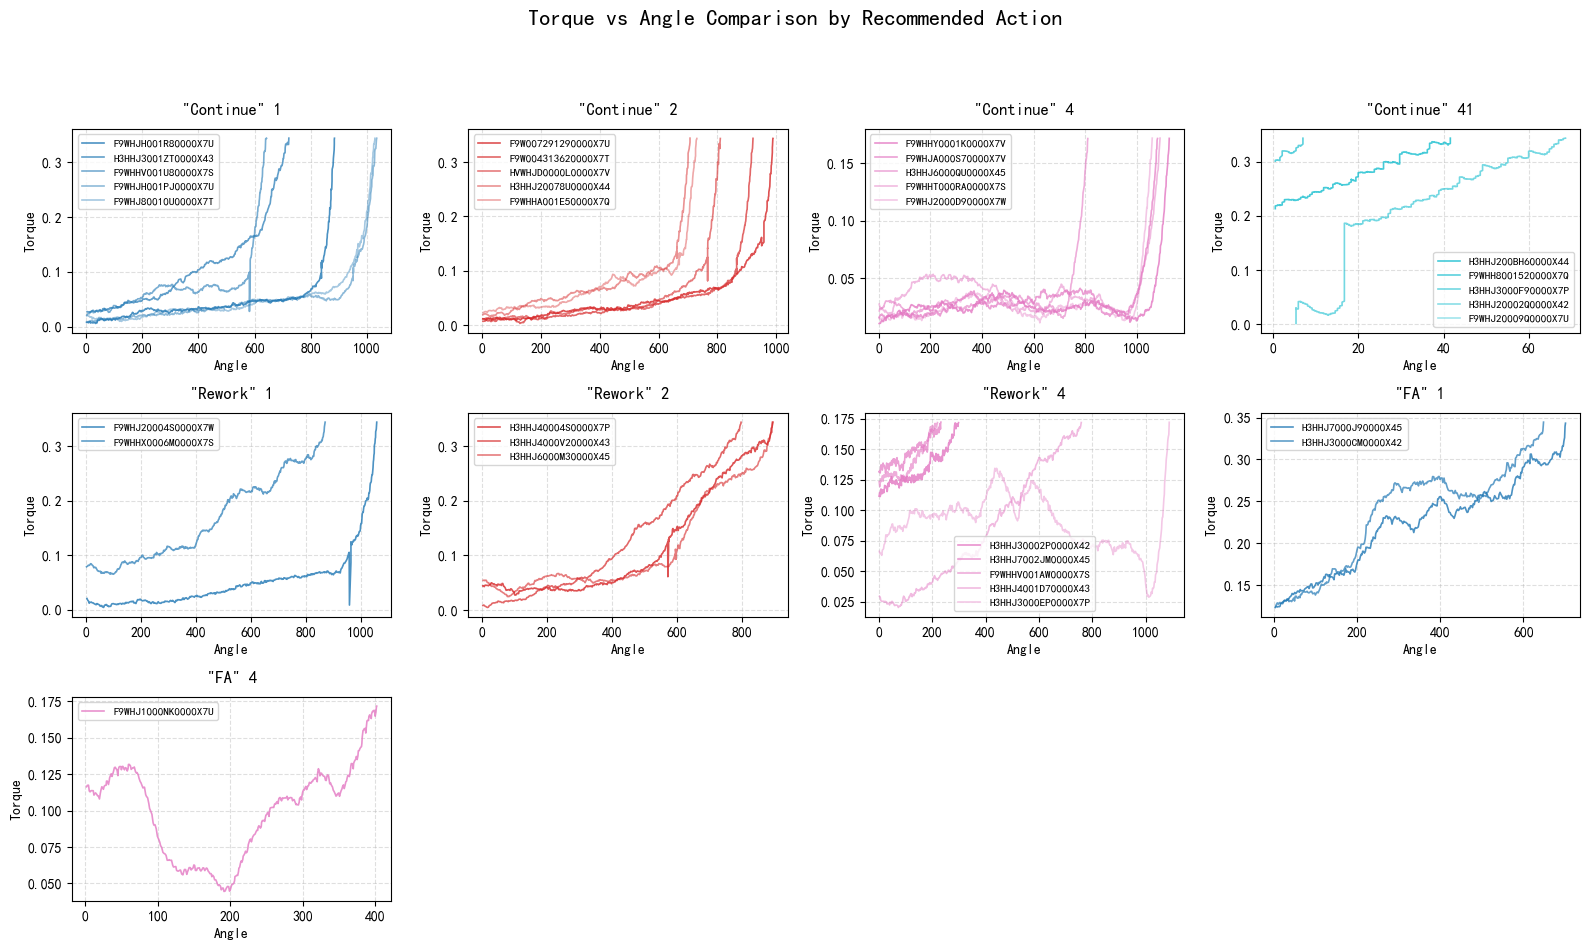

In [63]:
plot_comparison(valid_groups, grouped, screw_order, random_state=2)

## 2.2